In [21]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import datetime
from datetime import timedelta
from datetime import datetime
from google.colab import files
from tensorflow.keras.layers import Conv1D, Dense, LSTM, Bidirectional, Dropout, SimpleRNN, GRU, MaxPooling1D, Flatten, Dropout

In [22]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    plt.figure(figsize=(12, 6))

    if type(y) is list:
        for y_curr in y:
            plt.plot(x[start:end], y_curr[start:end], format)
    else:
        plt.plot(x[start:end], y[start:end], format)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend:
        plt.legend(legend)
    plt.title(title)
    plt.grid(True)
    plt.show()

# Get The Dataset

In [23]:
uploaded = files.upload()

Saving dummy_dataset_small.csv to dummy_dataset_small (1).csv


In [25]:
# Initialize lists
dates = []
sales = []
spend = []

# Open CSV file
with open('dummy_dataset_small.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)  # Skip header
    for row in reader:
        dates.append(datetime.strptime(row[0], '%Y-%m-%d'))
        sales.append(float(row[1]))
        spend.append(float(row[2]))

# Read the CSV file into a DataFrame
df = pd.read_csv('dummy_dataset_small.csv')

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Convert lists to numpy arrays
time = np.array(dates)
sales_series = np.array(sales)
spend_series = np.array(spend)

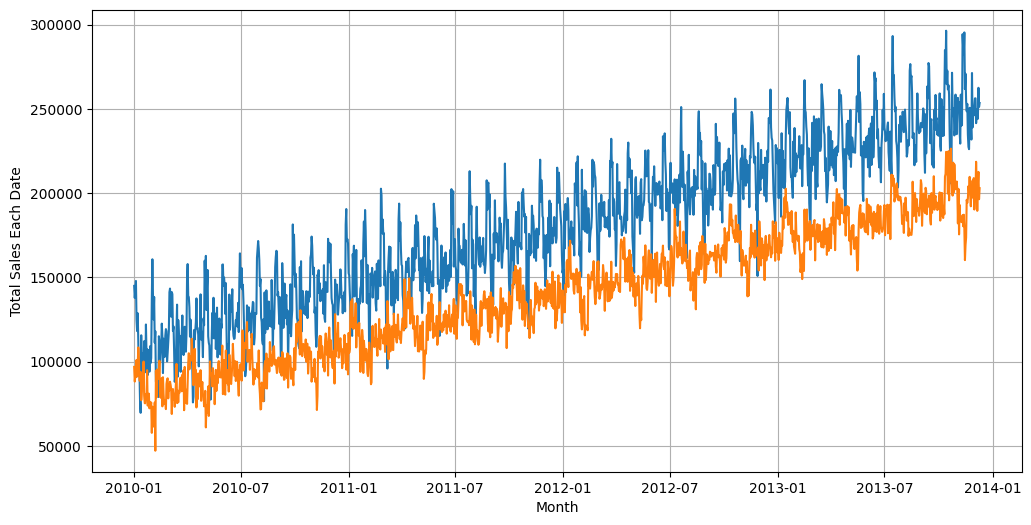

In [26]:
# Preview the data
plot_series(time, [sales_series, spend_series], xlabel='Month', ylabel='Total Sales Each Date')

In [27]:
# Split the data
ROW_COUNT = len(sales_series)
SPLIT_TIME = int(0.7 * ROW_COUNT)

time_train = time[:SPLIT_TIME]
x_train_sales = sales_series[:SPLIT_TIME]
x_train_spend = spend_series[:SPLIT_TIME]

time_valid = time[SPLIT_TIME:]
x_valid_sales = sales_series[SPLIT_TIME:]
x_valid_spend = spend_series[SPLIT_TIME:]

print(f"x_train_sales shape: {x_train_sales.shape}")
print(f"x_valid_sales shape: {x_valid_sales.shape}")

x_train_sales shape: (1007,)
x_valid_sales shape: (433,)


In [28]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """
    Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer (int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [29]:
WINDOW_SIZE = 240
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

In [30]:
# Combine sales and spend into a single multivariate series
x_train_multivariate = np.column_stack((x_train_sales, x_train_spend))
x_valid_multivariate = np.column_stack((x_valid_sales, x_valid_spend))

# Generate the dataset windows
train_set = windowed_dataset(x_train_multivariate, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER_SIZE)

In [31]:
# Build the Model

model = tf.keras.models.Sequential([
    Conv1D(filters=32, kernel_size=3, activation="relu", padding='causal', input_shape=[WINDOW_SIZE, 2]),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=64, kernel_size=3, activation="relu", padding='causal'),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=128, kernel_size=3, activation="relu", padding='causal'),
    MaxPooling1D(pool_size=2),

    Flatten(),

    Dense(10, activation="relu"),

    Dense(2),
])

In [32]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

In [33]:
# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam',
              metrics=["mae"])

In [35]:
history = model.fit(train_set, epochs=500)

Epoch 1/500
24/24 [==============================] - 1s 32ms/step - loss: 9416.7695 - mae: 9417.2695
Epoch 2/500
24/24 [==============================] - 1s 29ms/step - loss: 9354.2246 - mae: 9354.7246
Epoch 3/500
24/24 [==============================] - 1s 29ms/step - loss: 9506.2734 - mae: 9506.7734
Epoch 4/500
24/24 [==============================] - 1s 30ms/step - loss: 8536.3711 - mae: 8536.8711
Epoch 5/500
24/24 [==============================] - 1s 29ms/step - loss: 8829.8652 - mae: 8830.3652
Epoch 6/500
24/24 [==============================] - 1s 29ms/step - loss: 9646.8633 - mae: 9647.3633
Epoch 7/500
24/24 [==============================] - 1s 29ms/step - loss: 8531.0811 - mae: 8531.5811
Epoch 8/500
24/24 [==============================] - 1s 29ms/step - loss: 10013.3984 - mae: 10013.8984
Epoch 9/500
24/24 [==============================] - 1s 29ms/step - loss: 9407.3818 - mae: 9407.8818
Epoch 10/500
24/24 [==============================] - 1s 29ms/step - loss: 9540.6201 - ma

In [37]:
# Generate the validation dataset windows
valid_set = windowed_dataset(x_valid_multivariate, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER_SIZE)

# Evaluate the model on the training set
train_mae = model.evaluate(train_set)
print(f"Training MAE: {train_mae[1]}")

# Evaluate the model on the validation set
valid_mae = model.evaluate(valid_set)
print(f"Validation MAE: {valid_mae[1]}")

24/24 [==============================] - 0s 18ms/step - loss: 1566.2213 - mae: 1566.7213
Training MAE: 1566.7213134765625
7/7 [==============================] - 0s 13ms/step - loss: 9858.0527 - mae: 9858.5527
Validation MAE: 9858.552734375


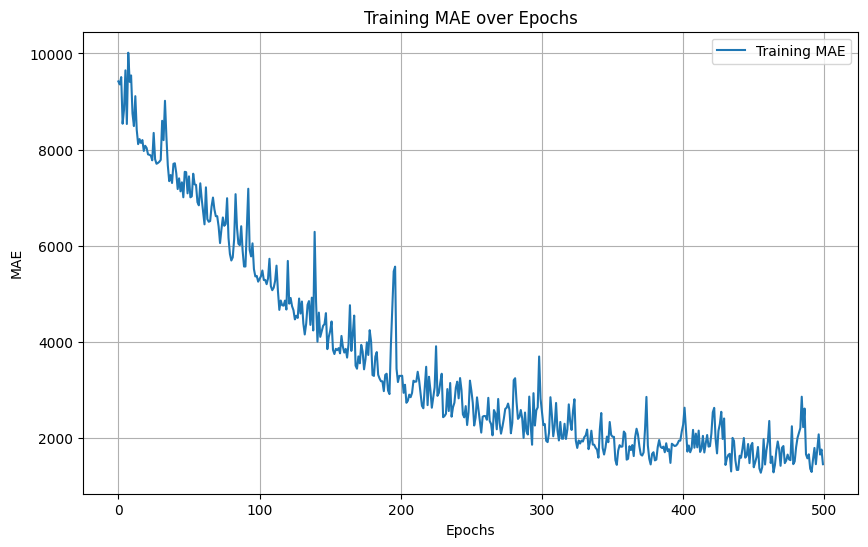

In [38]:
# Plot the training and validation MAE over epochs
mae = history.history['mae']
epochs = range(len(mae))

plt.figure(figsize=(10, 6))
plt.plot(epochs, mae, label='Training MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('Training MAE over Epochs')
plt.grid(True)
plt.show()

14/14 [==============================] - 1s 26ms/step


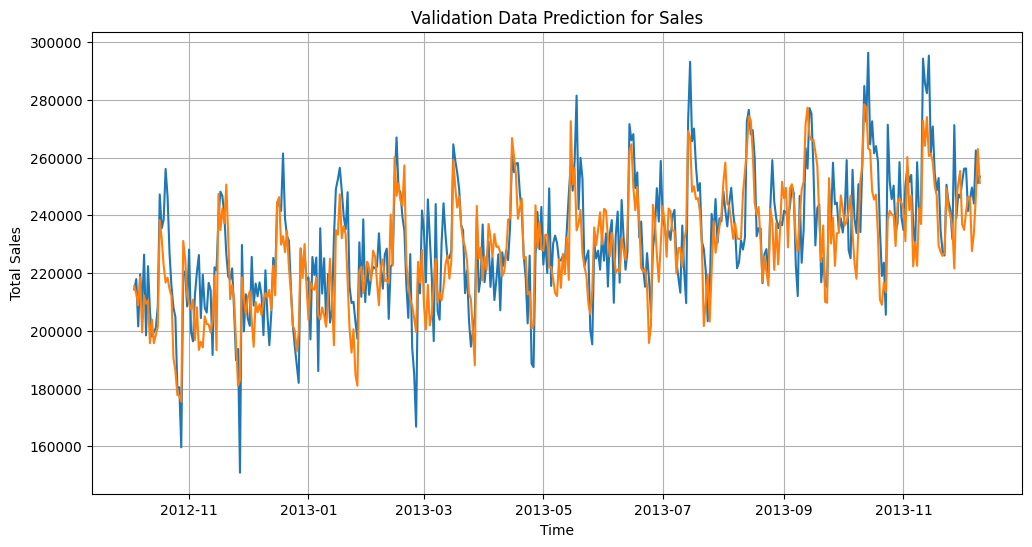

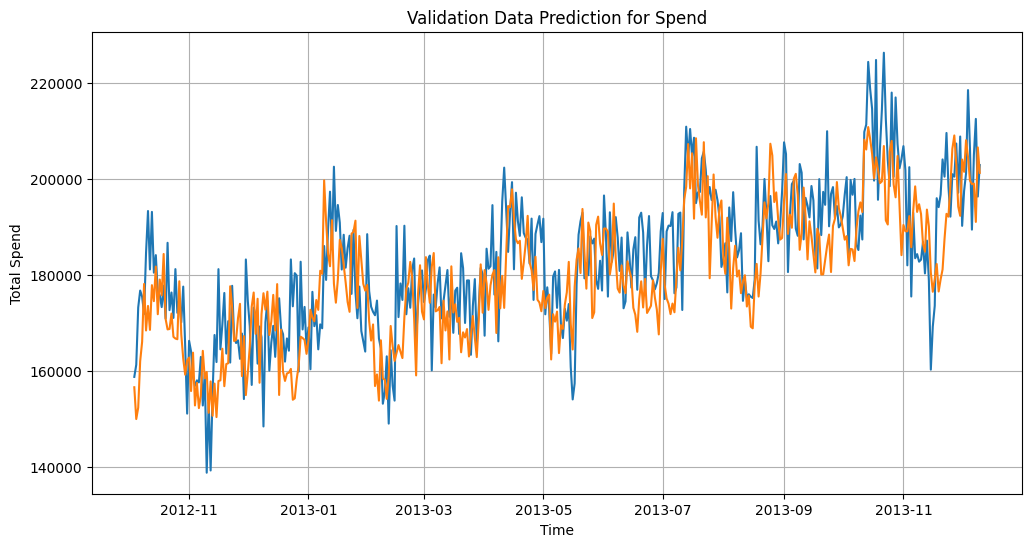

In [39]:
def model_forecast_multivariate(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows for multivariate data

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

# Combine sales and spend series into a single multivariate series
multivariate_series = np.vstack((sales_series, spend_series)).T

# Reduce the original series
forecast_series = multivariate_series[SPLIT_TIME - WINDOW_SIZE: -1]

# Use helper function to generate predictions
forecast = model_forecast_multivariate(model, forecast_series, WINDOW_SIZE, BATCH_SIZE)

# Plot the result
results_sales = forecast[:, 0]
results_spend = forecast[:, 1]

# Plot the sales and spend predictions
plot_series(time_valid, [x_valid_multivariate[:, 0], results_sales], title="Validation Data Prediction for Sales", xlabel="Time", ylabel="Total Sales")
plot_series(time_valid, [x_valid_multivariate[:, 1], results_spend], title="Validation Data Prediction for Spend", xlabel="Time", ylabel="Total Spend")


In [40]:
# Save the model
model.save('../ModelResult/dummy_small_dataset.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [41]:
def forecast_future(days=30):
    ### Prepare Data for Prediction
    max_date = df['Date'].max()
    future_dates = np.array([max_date + timedelta(days=i) for i in range(days)])
    future_sales = np.zeros((days, 2))  # Initialize array to store predicted values

    x_input = x_valid_multivariate[-WINDOW_SIZE:]  # Use last WINDOW_SIZE days of validation data as input
    x_input = np.column_stack((x_input[:, 0], x_input[:, 1]))  # Reshape input data

    ### Make Predictions
    for i in range(days):
        x_input = x_input.reshape((1, WINDOW_SIZE, 2))  # Reshape input data for model
        prediction = model.predict(x_input)  # Make prediction
        future_sales[i] = prediction  # Store predicted values
        x_input = np.roll(x_input, -1)  # Roll input data to make next prediction
        x_input[:, -1, :] = prediction  # Update input data with predicted values

    ### Plot the results
    results_sales = forecast[:, 0]
    results_spend = forecast[:, 1]

    ### Create a figure with two subplots
    fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    ### Plot validation data and predictions on the first part of each subplot
    ax[0].plot(time_valid, x_valid_multivariate[:, 0], label='Validation Sales')
    ax[0].plot(time_valid, results_sales, label='Predicted Sales')
    ax[0].set_title('Validation Data Prediction for Sales')
    ax[0].set_ylabel('Total Sales')
    ax[0].legend()

    ax[1].plot(time_valid, x_valid_multivariate[:, 1], label='Validation Spend')
    ax[1].plot(time_valid, results_spend, label='Predicted Spend')
    ax[1].set_title('Validation Data Prediction for Spend')
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('Total Spend')
    ax[1].legend()

    ### Plot predicted values for next 365 days on the same figure
    ax[0].plot(future_dates, future_sales[:, 0], label='Predicted Sales (Next 365 Days)')
    ax[1].plot(future_dates, future_sales[:, 1], label='Predicted Spend (Next 365 Days)')

    plt.tight_layout()
    plt.show()

1/1 [==============================] - 0s 20ms/step


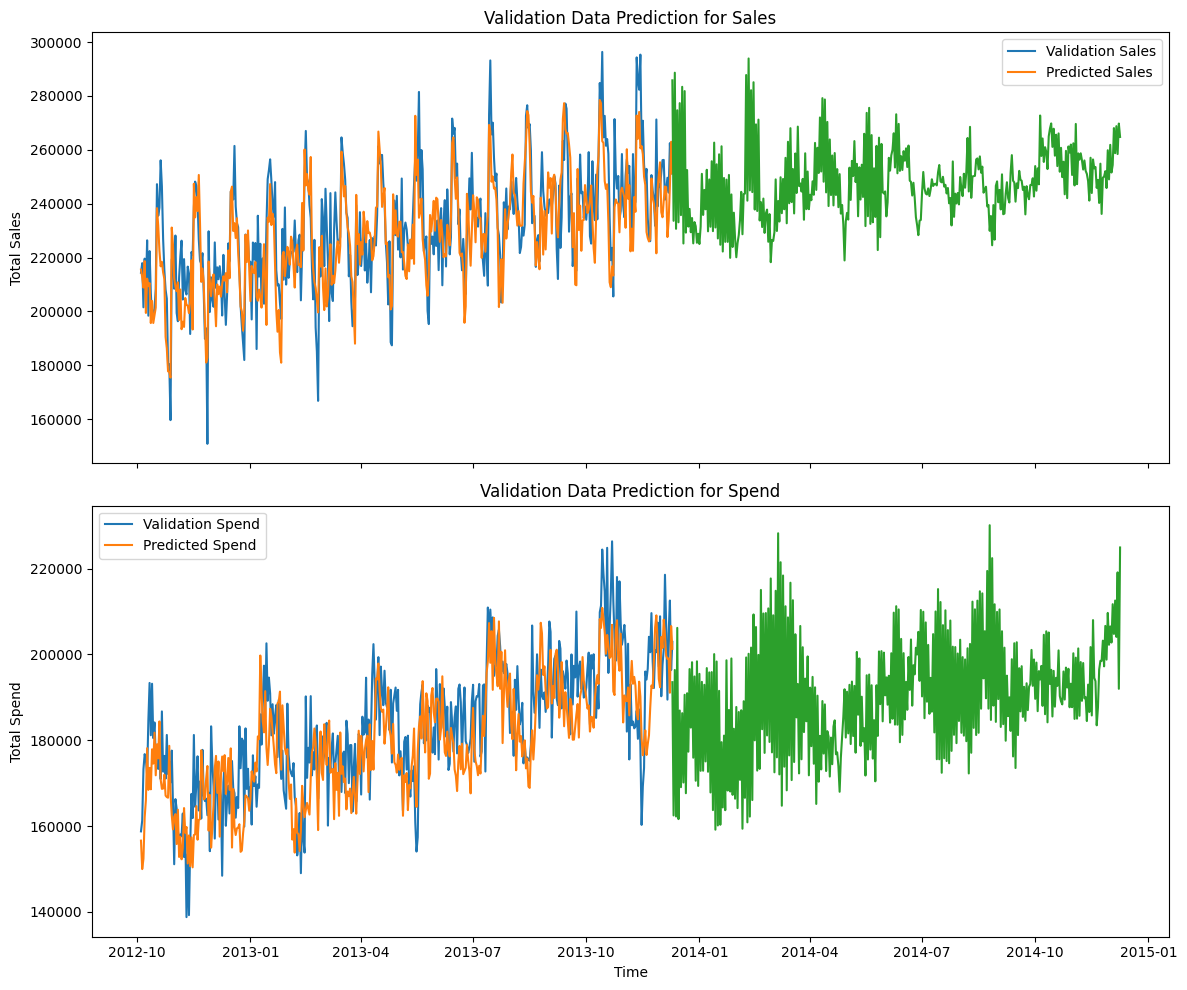

In [43]:
from tensorflow.keras.models import load_model

model = load_model('../ModelResult/dummy_small_dataset.h5')

forecast_future(365)

1/1 [==============================] - 0s 22ms/step


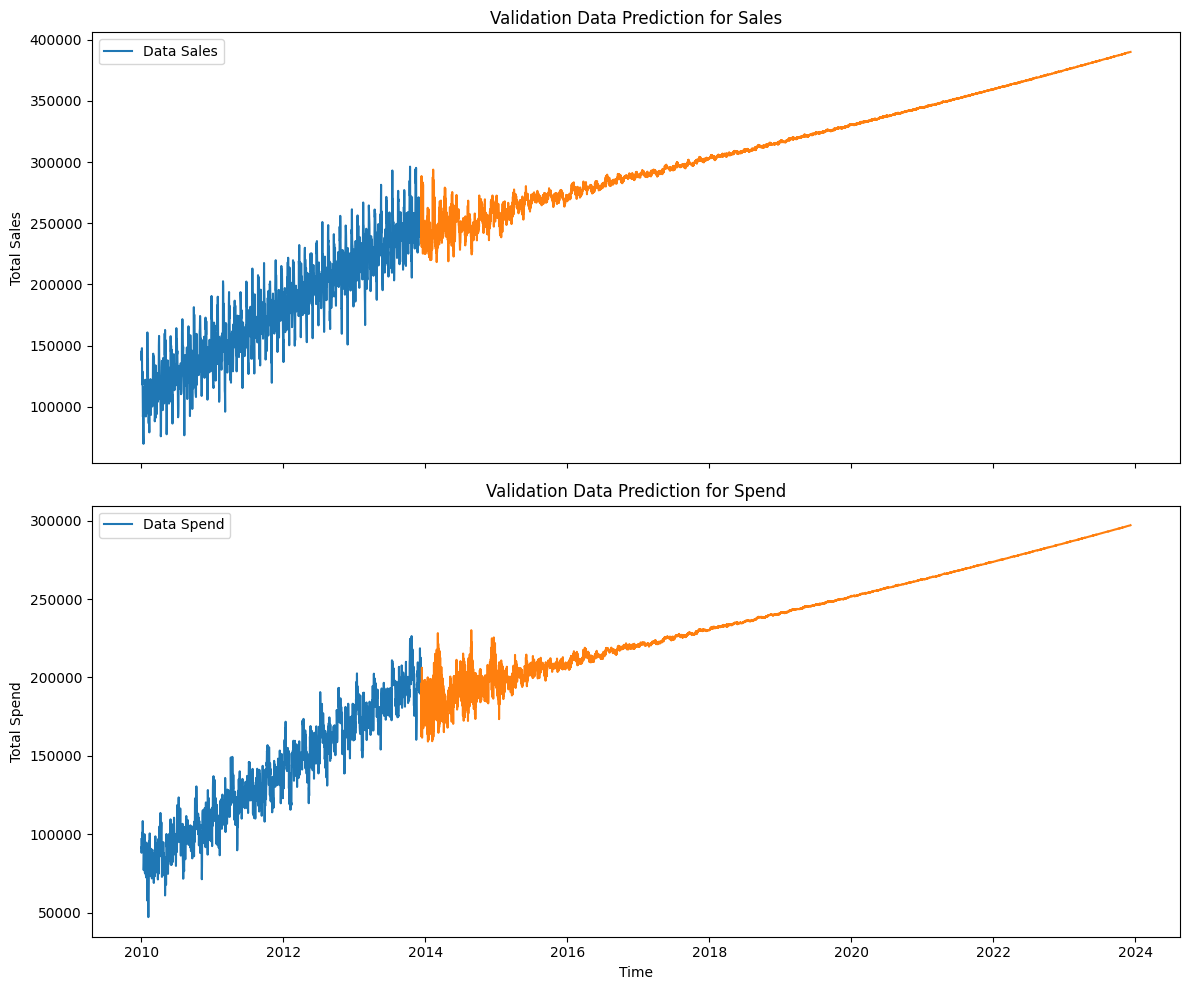

In [44]:
days = 3650

### Prepare Data for Prediction
max_date = df['Date'].max()
future_dates = np.array([max_date + timedelta(days=i) for i in range(days)])
future_sales = np.zeros((days, 2))  # Initialize array to store predicted values

sales_and_spend = np.column_stack((sales_series, spend_series))
x_init = sales_and_spend[-WINDOW_SIZE:]
x_init = np.column_stack((x_init[:, 0], x_init[:, 1]))

### Make Predictions
for i in range(days):
    x_init = x_init.reshape((1, WINDOW_SIZE, 2))  # Reshape input data for model
    prediction = model.predict(x_init)  # Make prediction
    future_sales[i] = prediction  # Store predicted values
    x_init = np.roll(x_init, -1)  # Roll input data to make next prediction
    x_init[:, -1, :] = prediction  # Update input data with predicted values

### Plot the results
results_sales = forecast[:, 0]
results_spend = forecast[:, 1]

### Create a figure with two subplots
fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

### Plot validation data and predictions on the first part of each subplot
ax[0].plot(time, sales_and_spend[:, 0], label='Data Sales')
ax[0].set_title('Validation Data Prediction for Sales')
ax[0].set_ylabel('Total Sales')
ax[0].legend()

ax[1].plot(time, sales_and_spend[:, 1], label='Data Spend')
ax[1].set_title('Validation Data Prediction for Spend')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Total Spend')
ax[1].legend()

### Plot predicted values for next 365 days on the same figure
ax[0].plot(future_dates, future_sales[:, 0], label=f'Predicted Sales (Next {days} Days)')
ax[1].plot(future_dates, future_sales[:, 1], label=f'Predicted Spend (Next {days} Days)')

plt.tight_layout()
plt.show()